First, lets create our Sagemaker session and role, and create a S3 prefix to use for the notebook example.

In [1]:
# S3 prefix
prefix = 'ems_call_volume'

import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

# Get a SageMaker-compatible role used by this Notebook Instance.
role = get_execution_role()

Couldn't call 'get_role' to get Role ARN from role name tyler.c.buffington@utexas.edu to get Role path.


ValueError: The current AWS identity is not a role: arn:aws:iam::445861113736:user/tyler.c.buffington@utexas.edu, therefore it cannot be used as a SageMaker execution role

In [2]:
import boto3
import sagemaker
from sagemaker import get_execution_role

# S3 prefix
prefix = 'ems_call_volume'
# session = boto3.session.Session(region_name='us-east-2')
# sagemaker_session = sagemaker.LocalSession(boto_session=session)
sagemaker_session = sagemaker.LocalSession()

# Get a SageMaker-compatible role used by this Notebook Instance.
# role = 'arn:aws:iam::467626235021:role/service-role/AmazonSageMaker-ExecutionRole-20190830T140378'
role = 'arn:aws:iam::445861113736:role/service-role/AmazonSageMaker-ExecutionRole-20190903T114521'

## Upload the data for training <a class="anchor" id="upload_data"></a>

I performed the following query to get the data. Right now, I'm just saving the dataframe as shown below.

In [3]:
#Generating the dataframe from NFORS
es = Elasticsearch()
s = Search(using=es,index='*-fire-incident-*')
s = s.source(['description.event_opened',
                     'weather.daily.precipIntensity',
                     'weather.daily.precipType',
                     'description.day_of_week',
                     'weather.daily.temperatureHigh',
                    'NFPA.type',
                     'fire_department.firecares_id'])



q = Q("match",fire_department__firecares_id =  '81154') | Q("match",fire_department__firecares_id =  '93345')
results = s.query(q)

#Performing the query and converting to pandas dataframe
df = pd.DataFrame((d.to_dict() for d in results.scan()))
json_struct = json.loads(df.to_json(orient="records"))

df = pd.io.json.json_normalize(json_struct)
df.to_json('./data/query_results.json')

NameError: name 'Elasticsearch' is not defined

Once we have the data locally, we can use use the tools provided by the SageMaker Python SDK to upload the data to a default bucket. 

In [3]:
WORK_DIRECTORY = 'data'
train_input = sagemaker_session.upload_data(WORK_DIRECTORY, key_prefix="{}/{}".format(prefix, WORK_DIRECTORY) )

## Create SageMaker Scikit Estimator <a class="anchor" id="create_sklearn_estimator"></a>

To run our Scikit-learn training script on SageMaker, we construct a `sagemaker.sklearn.estimator.sklearn` estimator, which accepts several constructor arguments:

* __entry_point__: The path to the Python script SageMaker runs for training and prediction.
* __role__: Role ARN
* __train_instance_type__ *(optional)*: The type of SageMaker instances for training. __Note__: Because Scikit-learn does not natively support GPU training, Sagemaker Scikit-learn does not currently support training on GPU instance types.
* __sagemaker_session__ *(optional)*: The session used to train on Sagemaker.
* __hyperparameters__ *(optional)*: A dictionary passed to the train function as hyperparameters.

To see the code for the SKLearn Estimator, see here: https://github.com/aws/sagemaker-python-sdk/tree/master/src/sagemaker/sklearn

In [4]:
from sagemaker.sklearn.estimator import SKLearn

script_path = 'ems_call_prediction.py'

sklearn = SKLearn(
    entry_point=script_path,
    train_instance_type="ml.c4.xlarge",
    role=role,
    sagemaker_session=sagemaker_session,
    hyperparameters={'n_estimators': 1000})

## Train SKLearn Estimator on EMS data <a class="anchor" id="train_sklearn"></a>
Training is very simple, just call `fit` on the Estimator! This will start a SageMaker Training job that will download the data for us, invoke our scikit-learn code (in the provided script file), and save any model artifacts that the script creates.

In [5]:
sklearn.fit({'train': train_input})

Creating tmp7294zq7f_algo-1-x7ddc_1 ... 
Attaching to tmp7294zq7f_algo-1-x7ddc_12mdone
algo-1-x7ddc_1  | 2020-01-09 20:19:43,580 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
algo-1-x7ddc_1  | 2020-01-09 20:19:43,585 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-x7ddc_1  | 2020-01-09 20:19:43,603 sagemaker_sklearn_container.training INFO     Invoking user training script.
algo-1-x7ddc_1  | 2020-01-09 20:19:43,902 sagemaker-containers INFO     Module ems_call_prediction does not provide a setup.py. 
algo-1-x7ddc_1  | Generating setup.py
algo-1-x7ddc_1  | 2020-01-09 20:19:43,903 sagemaker-containers INFO     Generating setup.cfg
algo-1-x7ddc_1  | 2020-01-09 20:19:43,903 sagemaker-containers INFO     Generating MANIFEST.in
algo-1-x7ddc_1  | 2020-01-09 20:19:43,903 sagemaker-containers INFO     Installing module with the following command:
algo-1-x7ddc_1  | /usr/bin/python3 -m pip install . 
algo-1-x7ddc_1  | Pro

===== Job Complete =====


## Using the trained model to make inference requests <a class="anchor" id="inference"></a>

### Deploy the model <a class="anchor" id="deploy"></a>

Deploying the model to SageMaker hosting just requires a `deploy` call on the fitted model. This call takes an instance count and instance type.

In [ ]:
predictor = sklearn.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

### Choose some data and use it for a prediction <a class="anchor" id="prediction_request"></a>

In order to do some predictions, we'll extract some of the data we used for training and do predictions against it. This is, of course, bad statistical practice, but a good way to see how the mechanism works.

In [ ]:
import os
import pandas as pd
import json
from sklearn.ensemble import RandomForestRegressor
from pandas.io.json import json_normalize
from dateutil.relativedelta import SU
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pandas.tseries.holiday import AbstractHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from pandas.tseries.holiday import Holiday
import datetime
from sklearn.externals import joblib
import numpy as np

dataloc = './prediction_data/test_data.json'
with open(dataloc) as data_file:
    data = json.load(data_file)
features = pd.io.json.json_normalize(data['prediction_data'])


#Converting df dates to datetime objects for holiday merging
features['date'] = features.apply(lambda x: datetime.datetime.strptime(x['date'],'%Y-%m-%d'),axis=1)

#We can create new rules with this class inheritance
class custom_calendar(AbstractHolidayCalendar):
    new_rules = [
        Holiday('Halloween', month=10,day=31),
        Holiday('Christmas Eve', month=12,day=24),
        Holiday('New Years Eve', month=12,day=31),
        Holiday('DST time change', month=3, day=1, offset=pd.DateOffset(weekday=SU(2)))
    ]
    rules = calendar().rules + new_rules

cal = custom_calendar()
start = np.min(features['date'])
end = np.max(features['date'])
holidays = cal.holidays(start=start,end=end,return_name=True).reset_index()
holidays = holidays.rename(columns={'index':'date', 0:'holiday'})

#But really we want the Monday after the time change
holidays['date'] = holidays.apply(lambda x: x['date'] + datetime.timedelta(days=1) 
               if x['holiday'] == 'DST time change' else x['date'], axis=1)

features = features.merge(holidays, on='date', how='left')
features['holiday'] = features['holiday'].fillna('none')
#Filling missing values with the average
features['high_temp'] = features['high_temp'].fillna(np.mean(features['high_temp']))

#No longer need the date since we have all the information we need (day of week and month)
features = features.drop('date',axis=1)
#Using one hot encoding for categorical variables. Ask me if you want me to explain this further.
features = pd.get_dummies(features)

#Splitting the data into features (predictors) and labels (the quantity we want to predict)
labels = features['ems_calls']
features = features.drop('ems_calls',axis=1)

Prediction is as easy as calling predict with the predictor we got back from deploy and the data we want to do predictions with. The output from the endpoint return an numerical representation of the classification prediction; in the original dataset, these are flower names, but in this example the labels are numerical. We can compare against the original label that we parsed.

In [ ]:
print(predictor.predict(features.values))

### Endpoint cleanup <a class="anchor" id="endpoint_cleanup"></a>

When you're done with the endpoint, you'll want to clean it up.

In [ ]:
sklearn.delete_endpoint()

## Batch Transform <a class="anchor" id="batch_transform"></a>
We can also use the trained model for asynchronous batch inference on S3 data using SageMaker Batch Transform.

In [7]:
# Define a SKLearn Transformer from the trained SKLearn Estimator
transformer = sklearn.transformer(instance_count=1, instance_type='ml.m4.xlarge')

### Prepare Input Data <a class="anchor" id="prepare_input_data"></a>
We will extract 10 random samples of 100 rows from the training data, then split the features (X) from the labels (Y). Then upload the input data to a given location in S3.

In [8]:
#Upload test data to s3
WORK_DIRECTORY = 'prediction_data'
batch_input_s3 = sagemaker_session.upload_data(WORK_DIRECTORY, key_prefix="{}/{}".format(prefix, WORK_DIRECTORY) )

### Run Transform Job <a class="anchor" id="run_transform_job"></a>
Using the Transformer, run a transform job on the S3 input data.

In [9]:
# Start a transform job and wait for it to finish
transformer.transform(batch_input_s3, content_type='application/json')
print('Waiting for transform job: ' + transformer.latest_transform_job.job_name)
transformer.wait()

Waiting for transform job: sagemaker-scikit-learn-2019-10-03-16-54-00-785
..................Processing /opt/ml/code
  Created wheel for ems-call-prediction: filename=ems_call_prediction-1.0.0-py2.py3-none-any.whl size=4932 sha256=da6007a06a48f17f4e7e5df2d689a325893003d2745ce572e099e3f44b42aebf
  Stored in directory: /tmp/pip-ephem-wheel-cache-i4ajwoa7/wheels/35/24/16/37574d11bf9bde50616c67372a334f94fa8356bc7164af8ca3
Successfully built ems-call-prediction
[2019-10-03 16:56:52 +0000] [37] [INFO] Starting gunicorn 19.9.0
[2019-10-03 16:56:52 +0000] [37] [INFO] Listening at: unix:/tmp/gunicorn.sock (37)
[2019-10-03 16:56:52 +0000] [37] [INFO] Using worker: gevent
[2019-10-03 16:56:52 +0000] [40] [INFO] Booting worker with pid: 40
[2019-10-03 16:56:52 +0000] [41] [INFO] Booting worker with pid: 41
[2019-10-03 16:56:52 +0000] [45] [INFO] Booting worker with pid: 45
[2019-10-03 16:56:52 +0000] [46] [INFO] Booting worker with pid: 46
2019-10-03 16:57:05,377 INFO - sagemaker-containers - No GP

### Check Output Data  <a class="anchor" id="check_output_data"></a>
After the transform job has completed, download the output data from S3. For each file "f" in the input data, we have a corresponding file "f.out" containing the predicted labels from each input row. We can compare the predicted labels to the true labels saved earlier.

In [10]:
# Download the output data from S3 to local filesystem
batch_output = transformer.output_path
!mkdir -p batch_data/output
!aws s3 cp --recursive $batch_output/ batch_data/output/
# Head to see what the batch output looks like
!head batch_data/output/*

download: s3://sagemaker-us-east-2-445861113736/sagemaker-scikit-learn-2019-10-03-16-54-00-785/test_data.json.out to batch_data/output/test_data.json.out
[14.262, 13.651, 13.776, 64.899, 32.359, 80.751, 119.24432222222221, 67.791, 14.291, 9.6, 77.111, 11.977, 71.26, 17.555, 76.62, 71.955, 65.988, 69.633, 72.4, 67.801, 16.868, 15.341, 14.491, 68.154, 73.672, 13.88, 11.946, 94.801953968254, 30.46, 76.214, 12.099, 32.963, 111.37256608946599, 75.409, 13.584, 10.49, 13.494, 14.924, 20.175, 13.632, 11.323, 79.148, 13.037, 13.741, 71.156, 12.984, 13.376, 71.529, 13.335, 14.749, 63.824, 73.622, 13.242, 10.425, 14.079, 70.725, 35.103, 14.916, 68.318, 16.027, 13.933, 13.86, 15.153, 61.511, 12.992, 69.234, 69.987, 13.4, 65.712, 11.144, 73.905, 63.855, 78.564, 69.216, 10.006, 12.519, 34.603, 65.763, 78.152, 13.837, 87.715, 13.497, 69.304, 68.77, 13.061, 69.625, 11.177, 9.125, 73.762, 69.42, 68.098, 70.547, 66.93, 16.691, 69.59, 16.193, 12.927, 73.688, 65.495, 72.673, 74.601, 66.103, 78.257, 14.602

In [73]:
# Pulling the predictions, comparing to the observed number of calls

Text(0, 0.5, 'actual')

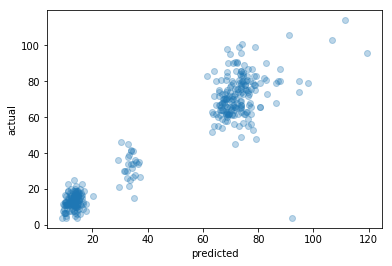

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
output_loc = './batch_data/output/test_data.json.out'

with open (output_loc, "r") as myfile:
    data=myfile.readlines()
    
string_output = data[0].replace('[','').replace(']','')

predicted = np.genfromtxt(StringIO(string_output),delimiter=',')
actual = np.genfromtxt('observed',delimiter=',')[1:,1]
plt.scatter(predicted,actual,alpha=0.3)
plt.xlabel('predicted')
plt.ylabel('actual')